In [22]:
# A check to see if environment variables are setup correctly:
import sys, math, random, ROOT, uproot, torch
import numpy as np

# h1 = ROOT.TH1F("h1", "h1", 10, 0, 500)
# h1.GetXaxis().SetTitle("random thing")
# h1.GetYaxis().SetTitle("events")

# for x in range(100000):
#     h1.Fill(random.randrange(0, 500))

# c = ROOT.TCanvas("c", "canvas", 400, 400)
# h1.Draw()
# c.Draw()

In [23]:
# now do stuff:
zttFile = ROOT.TFile("ztt_Output.root")
signal_tree = zttFile.Get("tauROI")

signal_entries = signal_tree.GetEntries()
print(signal_entries)

#signal_tree.Print()

17232


In [24]:
MB80File = ROOT.TFile("orig_output_MB80.root")
background_tree = MB80File.Get("mytree")

background_entries = background_tree.GetEntries()
print(background_entries)

background_tree.Print()

69049
******************************************************************************
*Tree    :mytree    : mytree                                                 *
*Entries :    69049 : Total =        37412556 bytes  File  Size =   26066792 *
*        :          : Tree compression factor =   1.43                       *
******************************************************************************
*Br    0 :bcid      : bcid/i                                                 *
*Entries :    69049 : Total  Size=     277334 bytes  File Size  =      26862 *
*Baskets :        9 : Basket Size=      32000 bytes  Compression=  10.31     *
*............................................................................*
*Br    1 :seed      : TLorentzVector                                         *
*Entries :    69049 : Total  Size=    4711393 bytes  File Size  =    2120327 *
*Baskets :      156 : Basket Size=      32000 bytes  Compression=   2.22     *
*.............................................

In [26]:
# Create a histogram of reconstructed Et of all signal and background events
h_signal = ROOT.TH1F("signal_recoEt", "signal_recoEt", 100, -20, 100)
h_signal.GetXaxis().SetTitle("Reconstructed Et")
h_signal.GetYaxis().SetTitle("Events")

h_background = ROOT.TH1F("background_recoEt", "background_recoEt", 100, -20, 100)
h_background.GetXaxis().SetTitle("Reconstructed Et")
h_background.GetYaxis().SetTitle("Events")

c = ROOT.TCanvas("c", "canvas", 400, 400)
#c1 = ROOT.TCanvas("c1", "canvas", 400, 400)
#c2 = ROOT.TCanvas("c2", "canvas", 400, 400)

# Construct reconstructed Et of each signal event and read into histogram
for i in range(signal_entries):
    signal_tree.GetEntry(i)
    
    # Each scells object is a tuple holding the energy of each cell in that layer
    # Read each tuple into a numpy array
    l0_cells = np.array(signal_tree.scellsEM0)
    l1_cells = np.array(signal_tree.scellsEM1)
    l2_cells = np.array(signal_tree.scellsEM2)
    l3_cells = np.array(signal_tree.scellsEM3)
    had_cells = np.array(signal_tree.scellsHAD)

    # Sum the energy of cells in each layer, then add all layers together
    # This gives the total reconstructed energy of the event
    reco_energy = (sum(l0_cells) + sum(l1_cells) + sum(l2_cells) + sum(l3_cells) + sum(had_cells)) / 1000.
    
    h_signal.Fill(reco_energy)
    
# Construct reconstructed Et of each signal event and read into histogram
for i in range(background_entries):
    background_tree.GetEntry(i)
    
    # Each scells object is a tuple holding the energy of each cell in that layer
    # Read each tuple into a numpy array
    for value in background_tree.L0CellEt:
        print(value)
    l0_cells = np.array(background_tree.L0CellEt)
    l1_cells = np.array(background_tree.L1CellEt)
    l2_cells = np.array(background_tree.L2CellEt)
    l3_cells = np.array(background_tree.L3CellEt)
    had_cells = np.array(background_tree.HadCellEt)

    # Sum the energy of cells in each layer, then add all layers together
    # This gives the total reconstructed energy of the event
    reco_energy = (sum(l0_cells) + sum(l1_cells) + sum(l2_cells) + sum(l3_cells) + sum(had_cells)) / 1000.
    
    if i == 0:
        print(l0_cells.shape)
        print(l1_cells.shape)
        print(l2_cells.shape)
        print(l3_cells.shape)
        print(had_cells.shape)
        print(sum(l0_cells))
        print(reco_energy)
    
    h_background.Fill(reco_energy)
    

(36,)
(156,)
(156,)
(36,)
(36,)
-1.3830479114006923e+35
nan


Warning in <TFile::Append>: Replacing existing TH1: signal_recoEt (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: background_recoEt (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


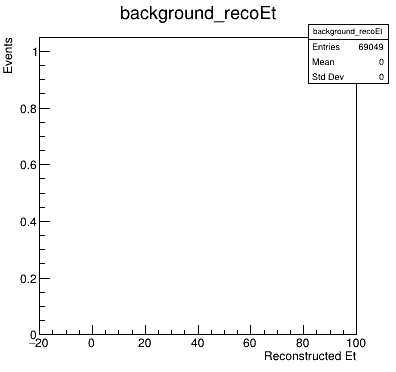

In [7]:
#h_signal.Draw()
#c1.Draw()
h_background.Draw()
#h_background.SetLineColor(0)
c.Draw()
#c2.Draw()